<a href="https://colab.research.google.com/github/djdtimit/Deep-Learning/blob/master/pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a pretrained convnet


large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes): ImageNet contains many animal classes, including different species of cats and dogs. Thus, it is expected that it will perform well on the dogs-versus-cats classification problems.

There are two ways to use a pretrained network. feature extraction and fine-tuning.


## Feature extraction

Feature extraction consists of using the representations learned by a prevoius network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

convnets consists of two parts:

- series of pooling and convolution layers -> convolutional base of the model
- end with a densely connected classifier

feature extraction: using the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

Why only reuse the convolutional base?

- representations learned by the convolutional base are likely to be more generic and therefore more reuseable -> contain the object location

- representaions learned by the classifier will be necessarily be specific to the set of classes on which the model was trained -> they will not contain information about where objects are located in the input image

level of generality depends on the depth of the layer in the model:

- earlier layers extract local, highly generic feature maps (edges, colors, and textures)

- higher layers extract more abstract concepts (cat ear or dog eye)

=> if new dataset differs a lot from the dataset on which the original model was trained: better off using only the first few layers do to feature extraction

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False, # not include the classifier
                  input_shape=(150,150,3))





58892288/58889256 [==============================] - 1s 0us/step




In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

two ways to proceed:

- Fast Feature Extraction without data augmentation

- Feature extraction with data augmentation

## Fast feature extraction without data augmentation

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/dogs_vs_cats/cats_and_dogs_small'

In [0]:
train_dir = os.path.join(base_dir, 'train')

In [0]:
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
test_dir = os.path.join(base_dir, 'test')

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size = 20

In [0]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i = 0
  for input_batch, labels_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

In [13]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
from keras import models
from keras import layers
from keras import optimizers

In [16]:
model = models.Sequential()
model.add(layers.Dense(units=256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
history = model.fit(x=train_features, y = train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 993us/step - loss: 0.7079 - acc: 0.7575 - val_loss: 0.4313 - val_acc: 0.7860
Epoch 2/30
2000/2000 [==============================] - 1s 423us/step - loss: 0.3476 - acc: 0.8540 - val_loss: 0.2607 - val_acc: 0.9010
Epoch 3/30
2000/2000 [==============================] - 1s 422us/step - loss: 0.2831 - acc: 0.8865 - val_loss: 0.2705 - val_acc: 0.8960
Epoch 4/30
2000/2000 [==============================] - 1s 420us/step - loss: 0.2502 - acc: 0.9030 - val_loss: 0.3544 - val_acc: 0.8660
Epoch 5/30
2000/2000 [==============================] - 1s 413us/step - loss: 0.2197 - acc: 0.9200 - val_loss: 0.2951 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 1s 431us/step - loss: 0.1904 - acc: 0.9245 - val_loss: 0.2621 - val_acc: 0.9020
Epoch 7/30
2000/2000 [==============================] - 1s 404us/step - loss: 0.1581 - acc: 0.9385 - val_loss: 0.3133 - val_acc: 0.8920


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
epochs = range(1, len(acc) + 1)

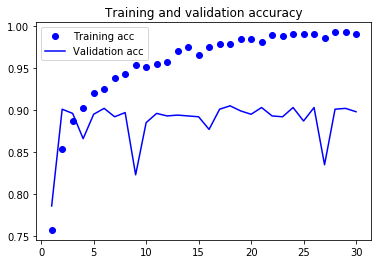

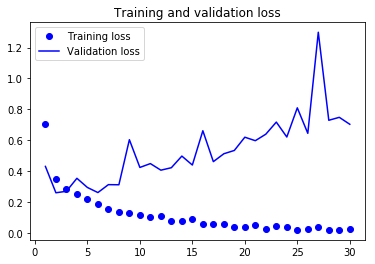

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

=> overfitting because no data augmentation, which is essential for preventing overfitting on small image datasets